# TensorFlow Tutorial #12
# Adversarial Noise for MNIST

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

The previous Tutorial #11 showed how to find so-called adversarial examples for a state-of-the-art neural network, which caused the network to mis-classify images even though they looked identical to the human eye. For example, an image of a parrot became mis-classified as a bookcase when adding the adversarial noise, but the image looked completely unchanged to the human eye.

The adversarial noise in Tutorial #11 was found through an optimization process for each individual image. Because the noise was specialized for each image, it may not generalize and have any effect on other images.

In this tutorial we will instead find adversarial noise that causes nearly all input images to become mis-classified as a desired target-class. The MNIST data-set of hand-written digits is used as an example. The adversarial noise is now clearly visible to the human eye, but the digits are still easily identified by a human, while the neural network mis-classifies nearly all the images.

In this tutorial we will also try and make the neural network immune to adversarial noise.

Tutorial #11 used NumPy for the adversarial optimization. In this tutorial we will show how to implement the optimization process directly in TensorFlow. This might be faster, especially when using a GPU, because it does not need to copy data to and from the GPU in each iteration.

It is recommended that you first study Tutorial #11. You should also be familiar with TensorFlow in general, see e.g. Tutorials #01 and #02.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.

This example shows an input image with a hand-written 7-digit. The adversarial noise is then added to the image. Red noise-pixels are positive and make the input image darker in those pixels, while blue noise-pixels are negative and make the input lighter in those pixels.

The noisy image is then fed to the neural network which results in a predicted class-number. In this case the adversarial noise fools the network into believing that the 7-digit shows a 3-digit. The noise is clearly visible to humans, but the 7-digit is still easily identified by a human.

The remarkable thing here, is that a single noise-pattern causes the neural network to mis-classify almost all input images to a desired target-class.

There are two separate optimization procedures in this neural network. First we optimize the variables of the neural network so as to classify images in the training-set. This is the normal optimization procedure for neural networks. Once the classification accuracy is good enough, we switch to the second optimization procedure, which tries to find a single pattern of adversarial noise, that causes all input images to be mis-classified as the given target-class.

The two optimization procedures are completely separate. The first procedure only modifies the variables of the neural network, while the second procedure only modifies the adversarial noise.

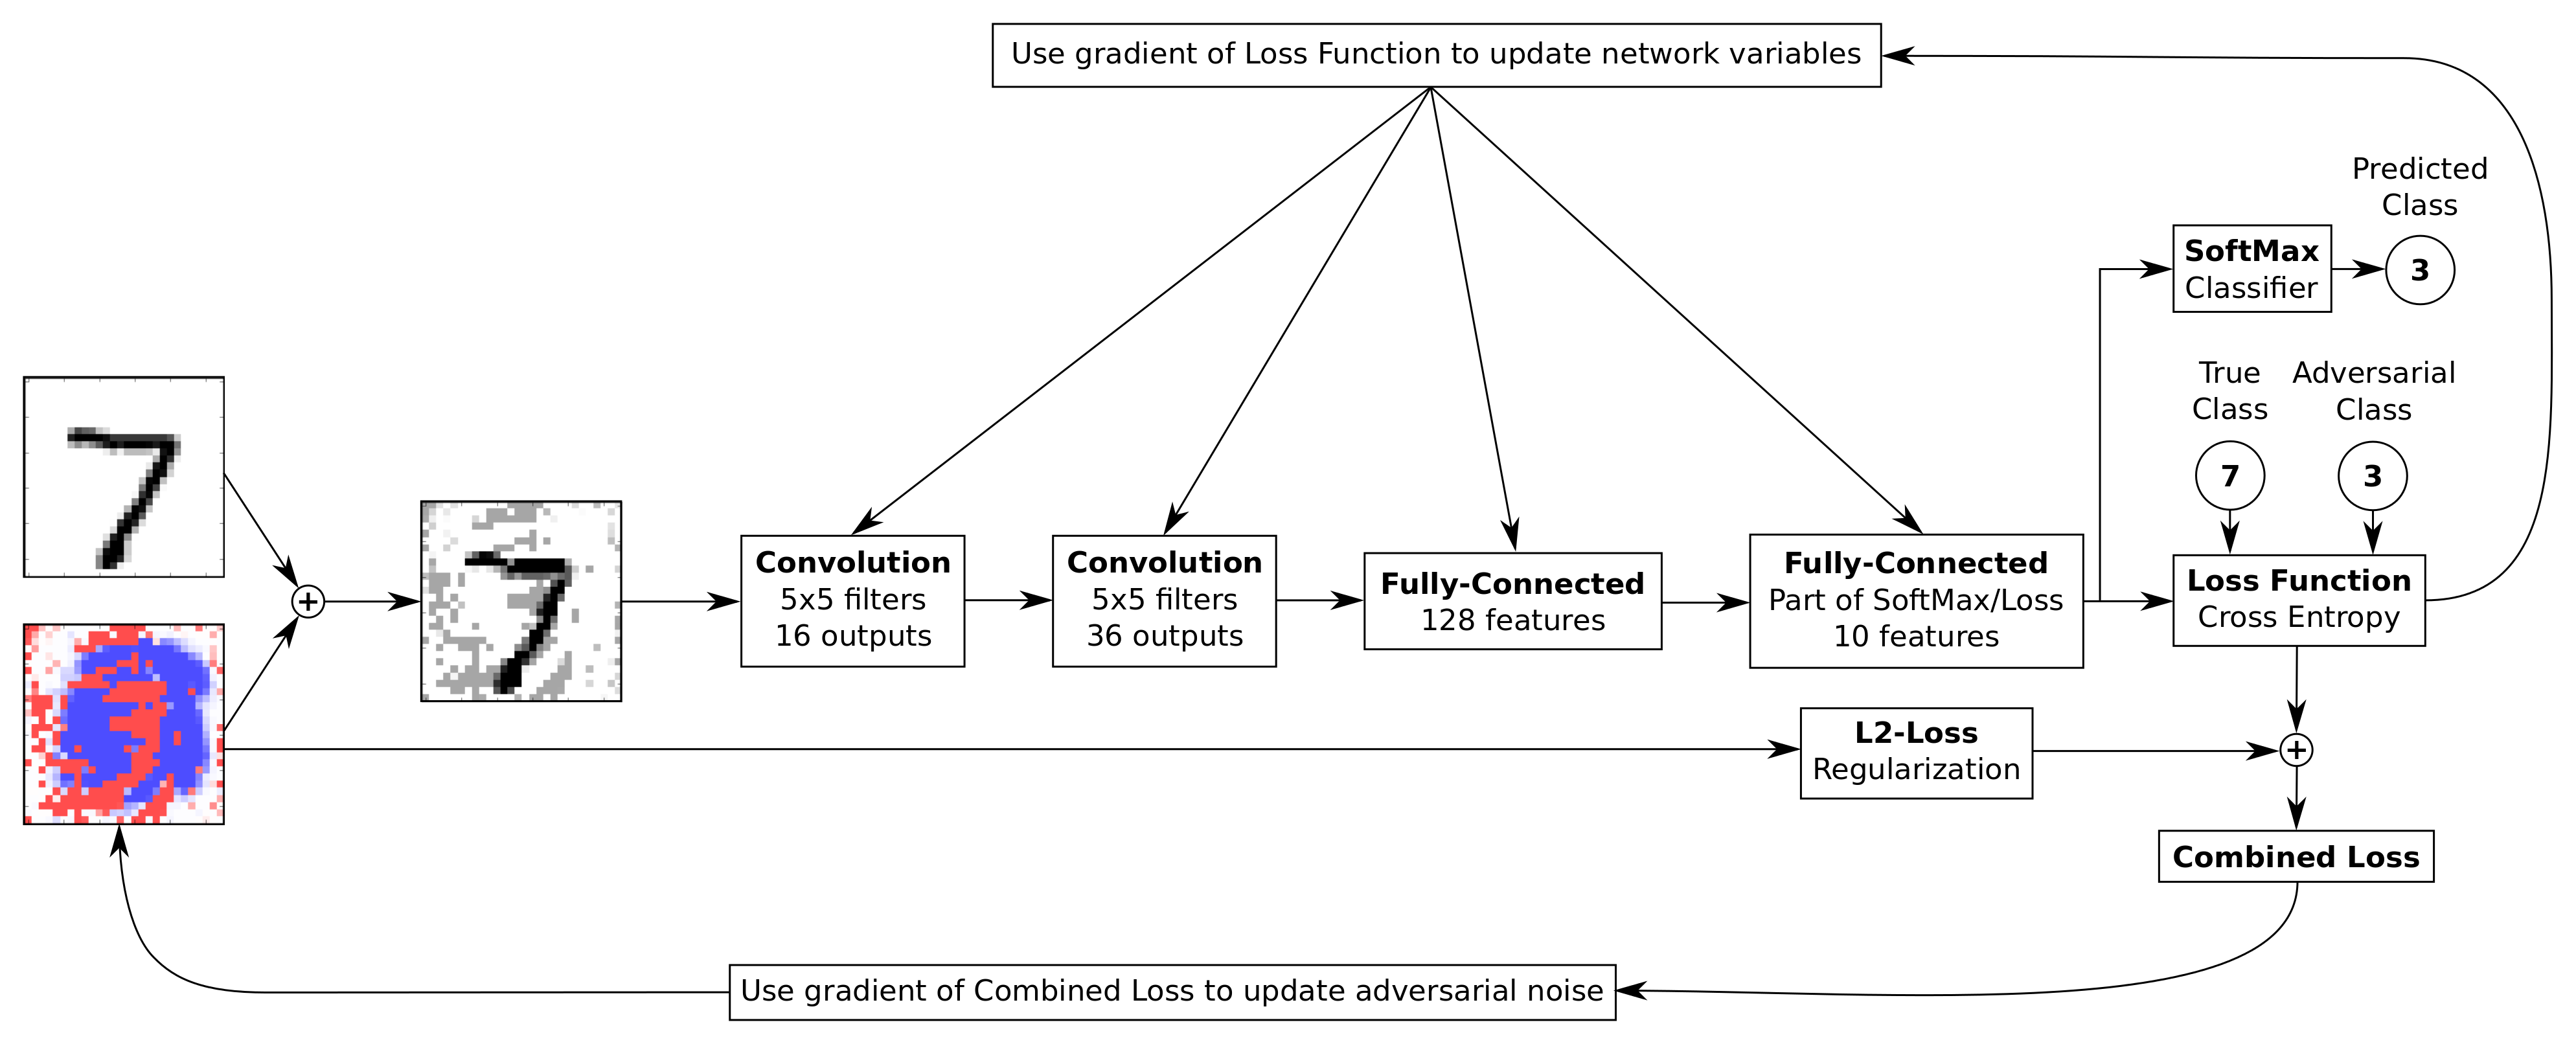

In [1]:
from IPython.display import Image
Image('images/12_adversarial_noise_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# We also need PrettyTensor.
import prettytensor as pt

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'0.12.0-rc0'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.1'

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)

### Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image. If the noise is supplied then it is added to all images.

In [9]:
def plot_images(images, cls_true, cls_pred=None, noise=0.0):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Get the i'th image and reshape the array.
        image = images[i].reshape(img_shape)
        
        # Add the adversarial noise to the image.
        image += noise
        
        # Ensure the noisy pixel-values are between 0 and 1.
        image = np.clip(image, 0.0, 1.0)

        # Plot image.
        ax.imshow(image,
                  cmap='binary', interpolation='nearest')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

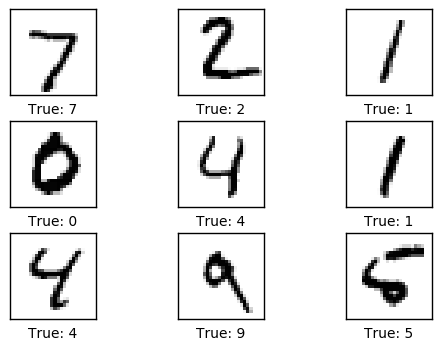

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The computational graph for the neural network will now be constructed using TensorFlow and PrettyTensor. As usual, we need to create placeholder variables for feeding images into the graph and then we add the adversarial noise to the images. The noisy images are then used as input to a convolutional neural network.

There are two separate optimization procedures for this network. A normal optimization procedure for the variables of the neural network itself, and another optimization procedure for the adversarial noise. Both optimization procedures are implemented directly in TensorFlow.

### Placeholder variables

Placeholder variables provide the input to the computational graph in TensorFlow that we may change each time we execute the graph. We call this feeding the placeholder variables.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [12]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [13]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [14]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Adversarial Noise

The pixels in the input image are float-values between 0.0 and 1.0. The adversarial noise is a number that is added or subtracted from the pixels in the input image.

The limit of the adversarial noise is set to 0.35 so the noise will be between &plusmn;0.35.

In [15]:
noise_limit = 0.35

The optimizer for the adversarial noise will try and minimize two loss-measures: (1) The normal loss-measure for the neural network, so we will find the noise that gives the best classification accuracy for the adversarial target-class; and (2) the so-called L2-loss-measure which tries to keep the noise as low as possible.

The following weight determines how important the L2-loss is compared to the normal loss-measure. An L2-weight close to zero usually works best.

In [16]:
noise_l2_weight = 0.02

When we create the new variable for the noise, we must inform TensorFlow which variable-collections that it belongs to, so we can later inform the two optimizers which variables to update.

First we define a name for our new variable-collection. This is just a string.

In [17]:
ADVERSARY_VARIABLES = 'adversary_variables'

Then we create a list of the collections that we want the new noise-variable to belong to. If we add the noise-variable to the collection `tf.GraphKeys.VARIABLES` then it will also get initialized with all the other variables in the TensorFlow graph, but it will not get optimized. This is a bit confusing.

In [18]:
collections = [tf.GraphKeys.VARIABLES, ADVERSARY_VARIABLES]

Now we can create the new variable for the adversarial noise. It will be initialized to zero. It will not be trainable, so it will not be optimized along with the other variables of the neural network. This allows us to create two separate optimization procedures.

In [19]:
x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]),
                      name='x_noise', trainable=False,
                      collections=collections)

The adversarial noise will be limited / clipped to the given 
&plusmn; noise-limit that we set above. Note that this is actually not executed at this point in the computational graph, but will instead be executed after the optimization-step, see further below.

In [20]:
x_noise_clip = tf.assign(x_noise, tf.clip_by_value(x_noise,
                                                   -noise_limit,
                                                   noise_limit))

The noisy image is just the sum of the input image and the adversarial noise.

In [21]:
x_noisy_image = x_image + x_noise

When adding the noise to the input image, it may overflow the boundaries for a valid image, so we clip / limit the noisy image to ensure its pixel-values are between 0 and 1.

In [22]:
x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)

### Convolutional Neural Network

We will use PrettyTensor to construct the convolutional neural network. First we need to wrap the tensor for the noisy image in a PrettyTensor-object, which provides functions that construct the neural network.

In [23]:
x_pretty = pt.wrap(x_noisy_image)

Now that we have wrapped the input image in a PrettyTensor object, we can add the convolutional and fully-connected layers in just a few lines of source-code.

In [24]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Note that `pt.defaults_scope(activation_fn=tf.nn.relu)` makes `activation_fn=tf.nn.relu` an argument for each of the layers constructed inside the `with`-block, so that Rectified Linear Units (ReLU) are used for each of these layers. The `defaults_scope` makes it easy to change arguments for all of the layers.

### Optimizer for Normal Training

This is a list of the variables for the neural network that will be trained during the normal optimization procedure. Note that `'x_noise:0'` is not in the list, so the adversarial noise is not being optimized in the normal procedure.

In [25]:
[var.name for var in tf.trainable_variables()]

['layer_conv1/weights:0',
 'layer_conv1/bias:0',
 'layer_conv2/weights:0',
 'layer_conv2/bias:0',
 'layer_fc1/weights:0',
 'layer_fc1/bias:0',
 'fully_connected/weights:0',
 'fully_connected/bias:0']

Optimization of these variables in the neural network is done with the Adam-optimizer using the loss-measure that was returned from PrettyTensor when we constructed the neural network above.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Optimizer for Adversarial Noise

Get the list of variables that must be optimized in the second procedure for the adversarial noise.

In [27]:
adversary_variables = tf.get_collection(ADVERSARY_VARIABLES)

Show the list of variable-names. There is only one, which is the adversarial noise variable that we created above.

In [28]:
[var.name for var in adversary_variables]

['x_noise:0']

We will combine the loss-function for the normal optimization with a so-called L2-loss for the noise-variable. This should result in the minimum values for the adversarial noise along with the best classification accuracy.

The L2-loss is scaled by a weight that is typically set close to zero.

In [29]:
l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(x_noise)

Combine the normal loss-function with the L2-loss for the adversarial noise.

In [30]:
loss_adversary = loss + l2_loss_noise

We can now create the optimizer for the adversarial noise. Because this optimizer is not supposed to update all the variables of the neural network, we must give it a list of the variables that we want updated, which is the variable for the adversarial noise. Also note the learning-rate is much greater than for the normal optimizer above.

In [31]:
optimizer_adversary = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary, var_list=adversary_variables)

We have now created two optimizers for the neural network, one for the variables of the neural network and another for the single variable with the adversarial noise.

### Performance Measures

We need a few more operations in the TensorFlow graph which will make it easier for us to display the progress to the user during optimization.

First we calculate the predicted class number from the output of the Neural Network `y_pred`, which is a vector with 10 elements. The class number is the index of the largest element.

In [32]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [33]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [34]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [35]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [36]:
session.run(tf.global_variables_initializer())

This is a helper-function for initializing / resetting the adversarial noise to zero.

In [37]:
def init_noise():
    session.run(tf.variables_initializer([x_noise]))

Call the function to initialize the adversarial noise.

In [38]:
init_noise()

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [39]:
train_batch_size = 64

Below is the function for performing a number of optimization iterations so as to gradually improve the variables of the neural network. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

This function is similar to the previous tutorials, except that it now takes an argument for the adversarial target-class. When this target-class is set to an integer, it will be used instead of the true class-number for the training-data. The adversarial optimizer is also used instead of the normal optimizer, and after each step of the adversarial optimizer, the noise will be limited / clipped to the allowed range. This optimizes the adversarial noise and ignores the other variables of the neural network.

In [40]:
def optimize(num_iterations, adversary_target_cls=None):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # If we are searching for the adversarial noise, then
        # use the adversarial target-class instead.
        if adversary_target_cls is not None:
            # The class-labels are One-Hot encoded.
            
            # Set all the class-labels to zero.
            y_true_batch = np.zeros_like(y_true_batch)

            # Set the element for the adversarial target-class to 1.
            y_true_batch[:, adversary_target_cls] = 1.0
            
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # If doing normal optimization of the neural network.
        if adversary_target_cls is None:
            # Run the optimizer using this batch of training data.
            # TensorFlow assigns the variables in feed_dict_train
            # to the placeholder variables and then runs the optimizer.
            session.run(optimizer, feed_dict=feed_dict_train)
        else:
            # Run the adversarial optimizer instead.
            # Note that we have 'faked' the class above to be
            # the adversarial target-class instead of the true class.
            session.run(optimizer_adversary, feed_dict=feed_dict_train)
            
            # Clip / limit the adversarial noise. This executes
            # another TensorFlow operation. It cannot be executed
            # in the same session.run() as the optimizer, because
            # it may run in parallel so the execution order is not
            # guaranteed. We need the clip to run after the optimizer.
            session.run(x_noise_clip)

        # Print status every 100 iterations.
        if (i % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-functions for getting and plotting the noise

This function gets the adversarial noise from inside the TensorFlow graph.

In [41]:
def get_noise():
    # Run the TensorFlow session to retrieve the contents of
    # the x_noise variable inside the graph.
    noise = session.run(x_noise)

    return np.squeeze(noise)

This function plots the adversarial noise and prints some statistics.

In [42]:
def plot_noise():
    # Get the adversarial noise from inside the TensorFlow graph.
    noise = get_noise()
    
    # Print statistics.
    print("Noise:")
    print("- Min:", noise.min())
    print("- Max:", noise.max())
    print("- Std:", noise.std())

    # Plot the noise.
    plt.imshow(noise, interpolation='nearest', cmap='seismic',
               vmin=-1.0, vmax=1.0)

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [43]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]

    # Get the adversarial noise from inside the TensorFlow graph.
    noise = get_noise()
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                noise=noise)

### Helper-function to plot confusion matrix

In [44]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

### Helper-function for showing the performance

Function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [45]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Normal optimization of neural network

First we perform 1000 optimization iterations with the normal optimizer. This finds the variables that makes the neural network perform well on the training-set.

The adversarial noise is not effective yet because it has only been initialized to zero above and it is not being updated during this optimization.

In [46]:
optimize(num_iterations=1000)

Optimization Iteration:      0, Training Accuracy:  12.5%
Optimization Iteration:    100, Training Accuracy:  90.6%
Optimization Iteration:    200, Training Accuracy:  84.4%
Optimization Iteration:    300, Training Accuracy:  84.4%
Optimization Iteration:    400, Training Accuracy:  89.1%
Optimization Iteration:    500, Training Accuracy:  87.5%
Optimization Iteration:    600, Training Accuracy:  93.8%
Optimization Iteration:    700, Training Accuracy:  93.8%
Optimization Iteration:    800, Training Accuracy:  93.8%
Optimization Iteration:    900, Training Accuracy:  96.9%
Optimization Iteration:    999, Training Accuracy:  92.2%
Time usage: 0:00:03


The classification accuracy is now about 96-97% on the test-set. (This will vary each time you run this Python Notebook).

Accuracy on Test-Set: 96.3% (9633 / 10000)
Example errors:


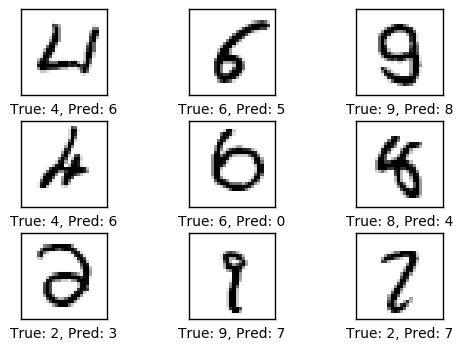

In [47]:
print_test_accuracy(show_example_errors=True)

## Find the adversarial noise

Before we start optimizing the adversarial noise, we first initialize it to zero. This was already done above but it is repeated here in case you want to re-run this code with another target-class.

In [48]:
init_noise()

Now perform optimization of the adversarial noise. This uses the adversarial optimizer instead of the normal optimizer, which means that it only optimizes the variable for the adversarial noise, while ignoring all the other variables of the neural network.

In [49]:
optimize(num_iterations=1000, adversary_target_cls=3)

Optimization Iteration:      0, Training Accuracy:   6.2%
Optimization Iteration:    100, Training Accuracy:  93.8%
Optimization Iteration:    200, Training Accuracy:  96.9%
Optimization Iteration:    300, Training Accuracy:  98.4%
Optimization Iteration:    400, Training Accuracy:  95.3%
Optimization Iteration:    500, Training Accuracy:  96.9%
Optimization Iteration:    600, Training Accuracy: 100.0%
Optimization Iteration:    700, Training Accuracy:  98.4%
Optimization Iteration:    800, Training Accuracy:  95.3%
Optimization Iteration:    900, Training Accuracy:  93.8%
Optimization Iteration:    999, Training Accuracy: 100.0%
Time usage: 0:00:03


The adversarial noise has now been optimized and it can be shown in a plot. The red pixels show positive noise-values and the blue pixels show negative noise-values. This noise-pattern is added to every input image. The positive (red) noise-values makes the pixels darker and the negative (blue) noise-values makes the pixels brighter. Examples of this are shown below.

Noise:
- Min: -0.35
- Max: 0.35
- Std: 0.195455


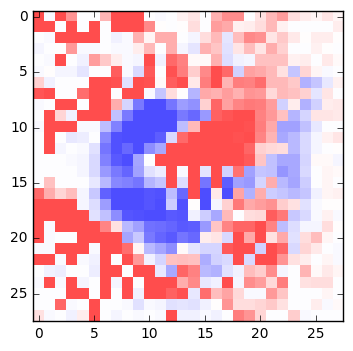

In [50]:
plot_noise()

When this noise is added to all the images in the test-set, the result is typically a classification accuracy of 10-15% depending on the target-class that was chosen. We can also see from the confusion matrix that most images in the test-set are now classified as the desired target-class - although some of the target-classes require more adversarial noise than others.

So we have found adversarial noise that makes the neural network mis-classify almost all images in the test-set as our desired target-class.

We can also show some examples of mis-classified images with the adversarial noise. The noise is clearly visible but the digits are still easily identified by the human eye.

Accuracy on Test-Set: 13.2% (1323 / 10000)
Example errors:


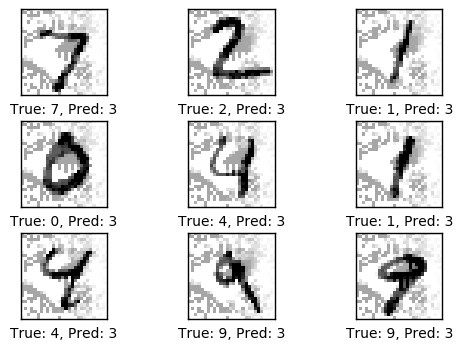

Confusion Matrix:
[[  85    0    0  895    0    0    0    0    0    0]
 [   0    0    0 1135    0    0    0    0    0    0]
 [   0    0   46  986    0    0    0    0    0    0]
 [   0    0    0 1010    0    0    0    0    0    0]
 [   0    0    0  959   20    0    0    0    3    0]
 [   0    0    0  847    0   45    0    0    0    0]
 [   0    0    0  914    0    1   42    0    1    0]
 [   0    0    0  977    0    0    0   51    0    0]
 [   0    0    0  952    0    0    0    0   22    0]
 [   0    0    1 1006    0    0    0    0    0    2]]


In [51]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Adversarial noise for all target-classes

This is a helper-function for finding the adversarial noise for all target-classes. The function loops over all the class-numbers from 0 to 9 and runs the optimization above. The results are then stored in an array.

In [52]:
def find_all_noise(num_iterations=1000):
    # Adversarial noise for all target-classes.
    all_noise = []

    # For each target-class.
    for i in range(num_classes):
        print("Finding adversarial noise for target-class:", i)

        # Reset the adversarial noise to zero.
        init_noise()

        # Optimize the adversarial noise.
        optimize(num_iterations=num_iterations,
                 adversary_target_cls=i)

        # Get the adversarial noise from inside the TensorFlow graph.
        noise = get_noise()

        # Append the noise to the array.
        all_noise.append(noise)

        # Print newline.
        print()
    
    return all_noise

In [53]:
all_noise = find_all_noise(num_iterations=300)

Finding adversarial noise for target-class: 0
Optimization Iteration:      0, Training Accuracy:   9.4%
Optimization Iteration:    100, Training Accuracy:  90.6%
Optimization Iteration:    200, Training Accuracy:  92.2%
Optimization Iteration:    299, Training Accuracy:  93.8%
Time usage: 0:00:01

Finding adversarial noise for target-class: 1
Optimization Iteration:      0, Training Accuracy:   7.8%
Optimization Iteration:    100, Training Accuracy:  62.5%
Optimization Iteration:    200, Training Accuracy:  62.5%
Optimization Iteration:    299, Training Accuracy:  75.0%
Time usage: 0:00:01

Finding adversarial noise for target-class: 2
Optimization Iteration:      0, Training Accuracy:   7.8%
Optimization Iteration:    100, Training Accuracy:  93.8%
Optimization Iteration:    200, Training Accuracy:  95.3%
Optimization Iteration:    299, Training Accuracy:  96.9%
Time usage: 0:00:01

Finding adversarial noise for target-class: 3
Optimization Iteration:      0, Training Accuracy:   6.2%

### Plot the adversarial noise for all target-classes

This is a helper-function for plotting a grid with the adversarial noise for all target-classes 0 to 9.

In [54]:
def plot_all_noise(all_noise):    
    # Create figure with 10 sub-plots.
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

    # For each sub-plot.
    for i, ax in enumerate(axes.flat):
        # Get the adversarial noise for the i'th target-class.
        noise = all_noise[i]
        
        # Plot the noise.
        ax.imshow(noise,
                  cmap='seismic', interpolation='nearest',
                  vmin=-1.0, vmax=1.0)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(i)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

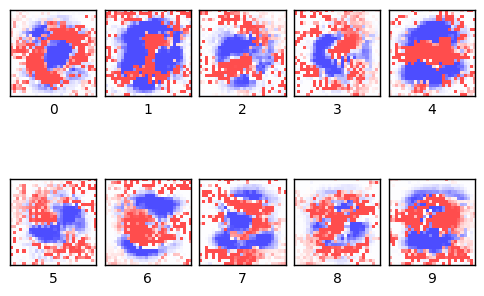

In [55]:
plot_all_noise(all_noise)

Red pixels show positive noise values, and blue pixels show negative noise values.

In some of these noise-images you can see traces of the numbers. For example, the noise for target-class 0 shows a red circle surrounded by blue. This means that a little noise will be added to the input image in the shape of a circle, and it will dampen the other pixels. This is sufficient for most input images in the MNIST data-set to be mis-classified as a 0. Another example is the noise for 3 which also shows traces of the number 3 with red pixels. But the noise for the other classes is less obvious.

## Immunity to adversarial noise

We will now try and make the neural network immune to adversarial noise. We do this by re-training the neural network to ignore the adversarial noise. This process can be repeated a number of times.

### Helper-function to make a neural network immune to noise

This is the helper-function for making the neural network immune to adversarial noise. First it runs the optimization to find the adversarial noise. Then it runs the normal optimization to make the neural network immune to that noise.

In [56]:
def make_immune(target_cls, num_iterations_adversary=500,
                num_iterations_immune=200):

    print("Target-class:", target_cls)
    print("Finding adversarial noise ...")

    # Find the adversarial noise.
    optimize(num_iterations=num_iterations_adversary,
             adversary_target_cls=target_cls)

    # Newline.
    print()
    
    # Print classification accuracy.
    print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False)

    # Newline.
    print()

    print("Making the neural network immune to the noise ...")

    # Try and make the neural network immune to this noise.
    # Note that the adversarial noise has not been reset to zero
    # so the x_noise variable still holds the noise.
    # So we are training the neural network to ignore the noise.
    optimize(num_iterations=num_iterations_immune)

    # Newline.
    print()
    
    # Print classification accuracy.
    print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False)

### Make immune to noise for target-class 3

First try and make the neural network immune to the adverserial noise for targer-class 3.

First we find the adversarial noise that causes the neural network to mis-classify most of the images in the test-set. Then we run the normal optimization which fine-tunes the variables of the neural network to ignore this noise and this brings the classification accuracy for the noisy images up to 95-97% again.

In [57]:
make_immune(target_cls=3)

Target-class: 3
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   3.1%
Optimization Iteration:    100, Training Accuracy:  93.8%
Optimization Iteration:    200, Training Accuracy:  93.8%
Optimization Iteration:    300, Training Accuracy:  96.9%
Optimization Iteration:    400, Training Accuracy:  96.9%
Optimization Iteration:    499, Training Accuracy:  96.9%
Time usage: 0:00:02

Accuracy on Test-Set: 14.4% (1443 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  42.2%
Optimization Iteration:    100, Training Accuracy:  90.6%
Optimization Iteration:    199, Training Accuracy:  89.1%
Time usage: 0:00:01

Accuracy on Test-Set: 95.3% (9529 / 10000)


Now try and run it again. It is now more difficult to find adversarial noise for the target-class 3. The neural network seems to have become somewhat immune to adversarial noise.

In [58]:
make_immune(target_cls=3)

Target-class: 3
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   7.8%
Optimization Iteration:    100, Training Accuracy:  32.8%
Optimization Iteration:    200, Training Accuracy:  32.8%
Optimization Iteration:    300, Training Accuracy:  29.7%
Optimization Iteration:    400, Training Accuracy:  34.4%
Optimization Iteration:    499, Training Accuracy:  26.6%
Time usage: 0:00:02

Accuracy on Test-Set: 72.1% (7207 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  75.0%
Optimization Iteration:    100, Training Accuracy:  93.8%
Optimization Iteration:    199, Training Accuracy:  92.2%
Time usage: 0:00:01

Accuracy on Test-Set: 95.2% (9519 / 10000)


### Make immune to noise for all target-classes

Now try and make the neural network immune to adversarial noise for all target-classes. Unfortunately this does not seem to work so well.

In [59]:
for i in range(10):
    make_immune(target_cls=i)
    
    # Print newline.
    print()

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   4.7%
Optimization Iteration:    100, Training Accuracy:  73.4%
Optimization Iteration:    200, Training Accuracy:  75.0%
Optimization Iteration:    300, Training Accuracy:  85.9%
Optimization Iteration:    400, Training Accuracy:  81.2%
Optimization Iteration:    499, Training Accuracy:  90.6%
Time usage: 0:00:02

Accuracy on Test-Set: 23.3% (2326 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  34.4%
Optimization Iteration:    100, Training Accuracy:  95.3%
Optimization Iteration:    199, Training Accuracy:  95.3%
Time usage: 0:00:01

Accuracy on Test-Set: 95.6% (9559 / 10000)

Target-class: 1
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:  12.5%
Optimization Iteration:    100, Training Accuracy:  57.8%
Optimization Iteration:    200, Training Accuracy:  62.5%
Optimization Iteration:    300, 

### Make immune to all target-classes (double runs)

Now try and use double-runs to make the neural network immune to adversarial noise for all target-classes. Unfortunately this does not seem to work so well either.

Making the neural network immune to one adversarial target-class appears to cancel the immunity towards the other target-classes.

In [60]:
for i in range(10):
    make_immune(target_cls=i)
    
    # Print newline.
    print()
    
    make_immune(target_cls=i)

    # Print newline.
    print()

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   7.8%
Optimization Iteration:    100, Training Accuracy:  53.1%
Optimization Iteration:    200, Training Accuracy:  73.4%
Optimization Iteration:    300, Training Accuracy:  79.7%
Optimization Iteration:    400, Training Accuracy:  84.4%
Optimization Iteration:    499, Training Accuracy:  95.3%
Time usage: 0:00:02

Accuracy on Test-Set: 29.2% (2921 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  29.7%
Optimization Iteration:    100, Training Accuracy:  96.9%
Optimization Iteration:    199, Training Accuracy:  95.3%
Time usage: 0:00:01

Accuracy on Test-Set: 96.2% (9619 / 10000)

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   1.6%
Optimization Iteration:    100, Training Accuracy:  12.5%
Optimization Iteration:    200, Training Accuracy:   7.8%
Optimization Iteration:    300, 

### Plot the adversarial noise

We have now performed many optimizations of both the neural network and the adversarial noise. Let us see how the adversarial noise looks now.

Noise:
- Min: -0.35
- Max: 0.35
- Std: 0.270488


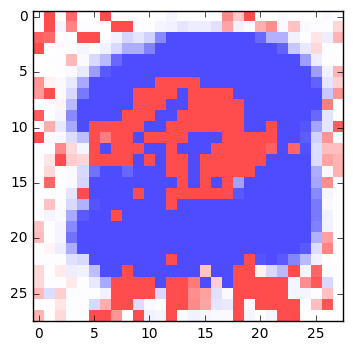

In [61]:
plot_noise()

Interestingly, the neural network now has a higher classification accuracy on noisy images than we had on clean images before all these optimizations.

Accuracy on Test-Set: 97.7% (9768 / 10000)
Example errors:


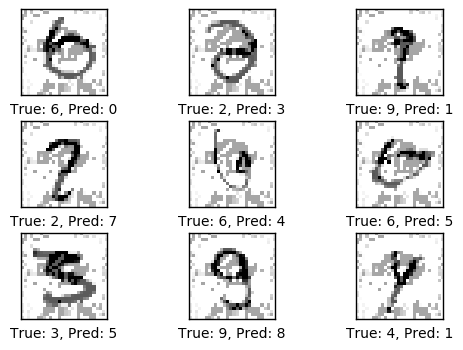

Confusion Matrix:
[[ 972    0    1    0    0    0    2    1    3    1]
 [   0 1119    4    0    0    2    2    0    8    0]
 [   3    0 1006    9    1    1    1    5    4    2]
 [   1    0    1  997    0    5    0    4    2    0]
 [   0    1    3    0  955    0    3    1    2   17]
 [   1    0    0    9    0  876    3    0    2    1]
 [   6    4    0    0    3    6  934    0    5    0]
 [   2    4   18    3    1    0    0  985    2   13]
 [   4    0    4    3    4    1    1    3  950    4]
 [   6    6    0    7    4    5    0    4    3  974]]


In [62]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Performance on clean images

Now let us see how the neural network performs on clean images so we reset the adversarial noise to zero.

In [63]:
init_noise()

The neural network now performs worse on clean images compared to noisy images.

Accuracy on Test-Set: 92.2% (9222 / 10000)
Example errors:


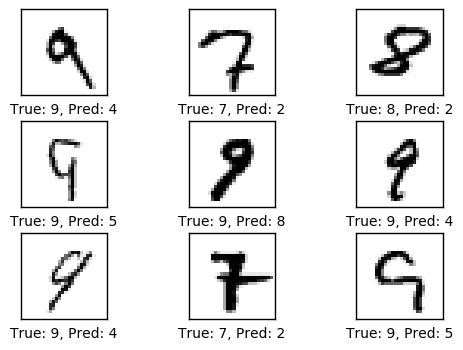

Confusion Matrix:
[[ 970    0    1    0    0    1    8    0    0    0]
 [   0 1121    5    0    0    0    9    0    0    0]
 [   2    1 1028    0    0    0    1    0    0    0]
 [   1    0   27  964    0   13    2    2    1    0]
 [   0    2    3    0  957    0   20    0    0    0]
 [   3    0    2    2    0  875   10    0    0    0]
 [   4    1    0    0    1    1  951    0    0    0]
 [  10   21   61    3   14    3    0  913    3    0]
 [  29    2   91    7    7   26   70    1  741    0]
 [  20   18   10   12  150   65   11   12    9  702]]


In [64]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [65]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Discussion

We saw in the experiments above that we were able to make the neural network immune to adversarial noise for a single target-class. This made it impossible to find adversarial noise that caused mis-classification to that target-class. But it was apparently not possible to make the neural network immune to all target-classes simultaneously. Perhaps this would be possible using another method.

One suggestion would be to interleave the immunity-training for different target-classes, instead of doing a full optimization for each target-class in turn. This should be possible with minor modifications to the source-code above.

Another suggestion would be to have two tiers of neural networks with 11 networks in total. The network in the first tier is used for classifying the input image. This network has not been made immune to adversarial noise. Another neural network from the second tier is then selected depending on the predicted class from the first tier. The networks in the second tier have been made immune to adversarial noise for their respective target-classes. So an adversary could fool the network in the first tier with adversarial noise, but the network in the second tier would be immune to noise for that particular target-class.

This might work for a small number of classes but it would become infeasible for larger numbers, e.g. the ImageNet data-set has 1000 classes so we would need to train 1000 neural networks for the second tier, which is not practical.

## Conclusion

This tutorial showed how to find adversarial noise for the MNIST data-set of hand-written digits. A single noise-pattern was found for each target-class, which caused almost all input images to become mis-classified as that target-class.

The noise-patterns for the MNIST data-set were clearly visible to the human eye. But it is possible that more subtle noise-patterns can be found for larger neural networks that work on higher-resolution images, e.g. the ImageNet data-set.

This tutorial also experimented with methods for making the neural network immune to adversarial noise. This worked well for a single target-class but the tested methods were not able to make the neural network simultaneously immune to all adversarial target-classes.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Try using fewer or more optimization iterations for the adversarial noise.
* Why does this tutorial require more optimization iterations than Tutorial #11, which needed less than 30 iterations to find the adversarial noise?
* Try different settings for `noise_limit` and `noise_l2_weight`. How does it affect the adversarial noise and classification accuracy?
* Try finding the adversarial noise for target-class 1. Does it work as well as for target-class 3?
* Can you find a better way to make the neural network immune to adversarial noise?
* Is the neural network immune to adversarial noise generated for individual images, as was done in Tutorial #11?
* Try making another neural network with a different configuration. Does the adversarial noise for one network also work on another network?
* Try using the CIFAR-10 data-set instead of MNIST. You may re-use some of the code from Tutorial #06.
* How would you find the adversarial noise for the Inception model and the ImageNet data-set?
* Explain to a friend how this program works.

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.